In [1]:
from leader_data import *
home_dir = os.path.abspath("..")  # Move up to the home directory
sys.path.append(home_dir)
from frengression import *
device = torch.device('cpu')


import numpy as np
import pickle
import os
from tqdm import tqdm
import torch.nn as nn
from copy import deepcopy

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import log_loss
from scipy.spatial.distance import pdist, squareform
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)


np.random.seed(42)


In [2]:
df_bsl=generate_bsl()
df_bsl.dropna(inplace=True)

In [3]:
df_outcome=generate_outcome()
df_outcome

df_Y = df_outcome[['USUBJID'] + [f'Y{i}' for i in range(1, 11)]]
df_I = df_outcome[['USUBJID'] + [f'I{i}' for i in range(1, 11)]]
df_D = df_outcome[['USUBJID'] + [f'D{i}' for i in range(1, 11)]]

df_Y


,USUBJID,Y1,Y2,Y3,Y4,Y5,Y6,Y7,Y8,Y9,Y10
1,EX2211-3748/5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,EX2211-3748/9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,EX2211-3748/16,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN
4,EX2211-3748/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,EX2211-3748/62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
9336,EX2211-3748/99915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9337,EX2211-3748/99921,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9338,EX2211-3748/99929,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9339,EX2211-3748/99971,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
ones_count = (df_Y.drop(columns=['USUBJID']) == 1).sum().sum()
ones_count

1302

In [5]:
df_egfr, df_hba1c, df_bmi = generate_longi_cov()

In [6]:
df_hba1c

,USUBJID,0,12,18,24,3,30,36,42,48,54,6,60,1,61
1,EX2211-3748/10012,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,NaN,NaN
2,EX2211-3748/10023,7.6,6.0,6.3,6.0,6.3,6.1,6.4,6.8,6.5,6.5,6.3,7.3,NaN,NaN
3,EX2211-3748/10028,9.9,9.5,7.9,9.6,8.4,9.2,9.9,9.6,9.6,9.6,8.6,9.6,NaN,NaN
4,EX2211-3748/10034,9.6,9.6,9.5,9.3,9.6,7.0,6.0,6.0,6.0,6.0,10.9,6.3,NaN,NaN
5,EX2211-3748/10050,7.5,7.8,8.9,8.7,8.0,8.5,8.1,8.1,8.1,8.1,6.3,9.6,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9336,EX2211-3748/99915,7.1,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,NaN,NaN
9337,EX2211-3748/99921,8.6,6.5,6.6,6.6,6.0,6.5,7.0,7.0,7.0,7.0,6.1,6.3,NaN,NaN
9338,EX2211-3748/99929,7.3,7.0,7.0,7.0,6.9,7.0,7.0,7.0,7.0,7.0,6.9,7.0,NaN,NaN
9339,EX2211-3748/99971,10.5,8.3,10.0,11.1,9.8,10.0,9.4,9.7,9.7,9.7,9.7,10.7,8.9,NaN


In [7]:
df_bmi

,USUBJID,0,12,24,36,48,6,60
1,EX2211-3748/10012,31.6,31.6,31.6,31.6,31.6,31.6,31.6
2,EX2211-3748/10023,39.0,37.3,37.3,38.2,39.5,38.5,39.9
3,EX2211-3748/10028,30.8,30.7,30.4,29.3,29.3,30.6,30.1
4,EX2211-3748/10034,41.4,42.6,41.7,30.4,30.4,41.9,29.5
5,EX2211-3748/10050,50.8,48.8,45.8,45.2,45.2,45.1,44.7
...,...,...,...,...,...,...,...,...
9327,EX2211-3748/99915,37.5,37.5,37.5,37.5,37.5,37.5,37.5
9328,EX2211-3748/99921,33.7,31.4,33.3,33.4,33.4,31.1,33.1
9329,EX2211-3748/99929,27.0,27.8,27.8,27.8,27.8,28.4,27.8
9330,EX2211-3748/99971,28.0,31.3,29.9,29.7,29.7,29.7,29.6


In [8]:
df_egfr

,USUBJID,0,12,24,36,48,6,60,61,30,42,1,18,3,54
1,EX2211-3748/10012,96.7,96.7,96.7,96.7,96.7,96.7,96.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,EX2211-3748/10023,84.3,89.5,91.2,86.8,84.3,91.2,84.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,EX2211-3748/10028,84.4,77.1,70.0,88.5,88.5,78.3,76.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,EX2211-3748/10034,75.5,91.0,83.3,78.0,78.0,79.2,92.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,EX2211-3748/10050,75.7,90.0,59.0,42.3,42.3,100.6,65.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9336,EX2211-3748/99915,79.8,79.8,79.8,79.8,79.8,79.8,79.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9337,EX2211-3748/99921,93.1,94.2,93.6,81.4,81.4,96.9,77.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9338,EX2211-3748/99929,105.1,107.0,107.0,107.0,107.0,93.6,107.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9339,EX2211-3748/99971,103.4,90.7,91.2,95.0,95.0,85.2,90.7,NaN,NaN,NaN,95.6,NaN,NaN,NaN


The longitudinal features are processed with these rules:
1. As hba1c has been measured several times, we use it as the benchmark for marking the records. However, we still discard month = 1 and month = 61 as there are not that many
2. Since egfr and bmi are measured less frequently, we impute the missing values using the observations in the previous visit time.
3. The simulated data will be evaluated by masking up intervals that the egfr and bmi are not recorded.


## exclude discrete variables, and consider only z1

In [9]:
import pandas as pd
import numpy as np
import torch
from copy import deepcopy

# ------------------------- Load Your Data -------------------------
df_z1 = deepcopy(df_hba1c)   # longitudinal covariate z1
df_z2 = deepcopy(df_egfr)    # longitudinal covariate z2
df_z3 = deepcopy(df_bmi)     # longitudinal covariate z3
df_bsl = deepcopy(df_bsl)    # baseline covariates
df_Y = deepcopy(df_Y)        # outcome
df_bsl.dropna(inplace=True)
# --------------------- Process df_Y (Outcome) ---------------------
# --------------------- Process df_Y (Outcome) ---------------------
if 'Y0' not in df_Y.columns:
    df_Y.insert(1, 'Y0', 0.0)
df_Y = df_Y[['USUBJID'] + [f'Y{i}' for i in range(0, 11)]]  # Y0 to Y10

# ----------------- Time Points You Care About ---------------------
time_points = [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60]

# ----------------- Longitudinal Processing Function -----------------
def process_longitudinal(df, time_points):
    df = df.loc[:, ['USUBJID'] + [str(tp) for tp in time_points if str(tp) in df.columns]].copy()
    for tp in time_points:
        col = str(tp)
        if col not in df.columns:
            df.loc[:, col] = np.nan
    df = df.loc[:, ['USUBJID'] + [str(tp) for tp in time_points]]

    df['na_count'] = df.isna().sum(axis=1)
    df = df.loc[df['na_count'] <= 5].drop(columns='na_count').reset_index(drop=True)

    for idx in range(len(df)):
        for t_idx, t in enumerate(time_points):
            col = str(t)
            if pd.isna(df.loc[idx, col]):
                for prev_t in reversed(time_points[:t_idx]):
                    prev_col = str(prev_t)
                    if not pd.isna(df.loc[idx, prev_col]):
                        df.loc[idx, col] = df.loc[idx, prev_col]
                        break

    return df

# ------------- Process and Clean z1, z2, z3 ----------------
df_z1_clean = process_longitudinal(df_z1, time_points)
df_z2_clean = process_longitudinal(df_z2, time_points)
df_z3_clean = process_longitudinal(df_z3, time_points)


df_z1_clean = df_z1_clean.dropna(axis=0, how='any').reset_index(drop=True)
df_z2_clean = df_z2_clean.dropna(axis=0, how='any').reset_index(drop=True)
df_z3_clean = df_z3_clean.dropna(axis=0, how='any').reset_index(drop=True)



# # ----------- Special fill for z3 missing months ----------------
# for target, source in [(18,12), (42,36), (54,48)]:
#     target, source = str(target), str(source)
#     if target not in df_z3_clean.columns:
#         df_z3_clean[target] = np.nan
#     df_z3_clean.loc[:, target] = df_z3_clean.loc[:, target].fillna(df_z3_clean.loc[:, source])

# df_z3_clean = process_longitudinal(df_z3_clean, time_points)

# ------------ Align All by Intersection of USUBJID -------------
common_ids = set(df_Y['USUBJID']) & set(df_z1_clean['USUBJID']) & set(df_z2_clean['USUBJID']) & set(df_z3_clean['USUBJID']) & set(df_bsl['USUBJID'])
df_Y = df_Y[df_Y['USUBJID'].isin(common_ids)].reset_index(drop=True)
df_z1_clean = df_z1_clean[df_z1_clean['USUBJID'].isin(common_ids)].reset_index(drop=True)
df_z2_clean = df_z2_clean[df_z2_clean['USUBJID'].isin(common_ids)].reset_index(drop=True)
df_z3_clean = df_z3_clean[df_z3_clean['USUBJID'].isin(common_ids)].reset_index(drop=True)
df_bsl = df_bsl[df_bsl['USUBJID'].isin(common_ids)].reset_index(drop=True)

# ------------ Sort all by USUBJID to align ----------------------
df_Y.sort_values(by='USUBJID', inplace=True)
df_z1_clean.sort_values(by='USUBJID', inplace=True)
df_z2_clean.sort_values(by='USUBJID', inplace=True)
df_z3_clean.sort_values(by='USUBJID', inplace=True)
df_bsl.sort_values(by='USUBJID', inplace=True)

# ----------------- Build the Z torch tensor (longitudinal) ----------------------
Z_list = []
for idx in range(len(df_z1_clean)):
    z1_vals = df_z1_clean.iloc[idx][[str(tp) for tp in time_points]].astype(float).values
    z2_vals = df_z2_clean.iloc[idx][[str(tp) for tp in time_points]].astype(float).values
    z3_vals = df_z3_clean.iloc[idx][[str(tp) for tp in time_points]].astype(float).values
    # Z_subj = np.column_stack([z1_vals, z2_vals, z3_vals]).reshape(-1)
    Z_subj = np.column_stack([z1_vals]).reshape(-1)
    Z_list.append(Z_subj.astype(np.float32))

z_tensor = torch.tensor(np.vstack(Z_list), dtype=torch.float32)  # Shape (n_subjects, 33)

# ----------------- Build the X tensor (ARM repeated over time) -------------------
# Pull ARM values
arm_values = df_bsl['ARM'].astype(float).values  # shape (n_subjects,)
x_tensor = torch.tensor(np.repeat(arm_values[:, np.newaxis], len(time_points), axis=1), dtype=torch.int32)
# Shape: (n_subjects, 11) => ARM repeated for 11 time steps

# ------------------ Build the y torch tensor ----------------------
y_cols = [f'Y{i}' for i in range(0, 11)]
y_np = df_Y[y_cols].astype(float).values  # Ensure it's float, so NaN is preserved
y_tensor = torch.tensor(y_np, dtype=torch.int32)

# ----------------- Build the S tensor (baseline features) -------------------
# Optional: Drop USUBJID since it's only for alignment
df_bsl_features = df_bsl.drop(columns=['USUBJID','ARM',  'RACE_AMERICAN.INDIAN.OR.ALASKA.NATIVE',
    'RACE_NATIVE.HAWAIIAN.OR.OTHER.PACIFIC.ISLANDER',
    'RACE_OTHER',
    'RACE_ASIAN',
    'RACE_BLACK.OR.AFRICAN.AMERICAN','SEX_F', 'SMOKER_CURRENT.SMOKER',
       'SMOKER_NEVER.SMOKED', 'MIFL', 'STROKEFL', 'STENFL', 'NEPSCRFL',
       'KIDFL', "HBA1CBL"
    ])
# df_bsl_features = df_bsl['AGE']
# # Optional safety: double check it's numeric for torch
df_bsl_features = df_bsl_features.astype(float)
x_bsl_tensor = torch.tensor(df_bsl['ARM'].values, dtype=torch.int32).view(-1, 1)

# Create the s_tensor
s_tensor = torch.tensor(df_bsl_features.values, dtype=torch.float32)

# ----------------- Check shape -------------------
print(f"s_tensor shape: {s_tensor.shape}")  # (n_subjects, num_baseline_features)


# ------------------ Print shapes to verify -----------------------
print(f"z_tensor shape: {z_tensor.shape}")  # (n_subjects, 33)
print(f"x_tensor shape (ARM): {x_tensor.shape}")  # (n_subjects, 11)
print(f"y_tensor shape: {y_tensor.shape}")  # (n_subjects, 11)

# Optional: Sanity check USUBJID order alignment
print(np.all(df_Y['USUBJID'].values == df_z1_clean['USUBJID'].values) and np.all(df_Y['USUBJID'].values == df_bsl['USUBJID'].values))
print(torch.isnan(y_tensor).any())  # Should return True if any NaN exists
assert not df_z1_clean.isnull().values.any(), "NaN detected in z1"
assert not df_z2_clean.isnull().values.any(), "NaN detected in z2"
assert not df_z3_clean.isnull().values.any(), "NaN detected in z3"


s_tensor shape: torch.Size([9161, 8])
z_tensor shape: torch.Size([9161, 11])
x_tensor shape (ARM): torch.Size([9161, 11])
y_tensor shape: torch.Size([9161, 11])
True
tensor(False)


In [10]:
p = s_tensor.shape[1]
print(f'number of covariates: {p}')
binary_intervention = True


model_bsl = Frengression(x_bsl_tensor.shape[1], y_tensor.shape[1], s_tensor.shape[1], noise_dim=1, num_layer=3, hidden_dim=100, device=device, x_binary = binary_intervention, z_binary_dims=0)
model_bsl.train_xz(x_bsl_tensor, s_tensor, num_iters=8000, lr=1e-3, print_every_iter=1000)

number of covariates: 8
Epoch 1: loss 116.0353, loss1 116.1943, loss2 0.3180
Epoch 1000: loss 20.9566, loss1 40.4359, loss2 38.9586
Epoch 2000: loss 20.8691, loss1 39.6311, loss2 37.5240
Epoch 3000: loss 20.8518, loss1 39.9529, loss2 38.2021
Epoch 4000: loss 20.7061, loss1 40.5049, loss2 39.5976
Epoch 5000: loss 20.7732, loss1 40.4380, loss2 39.3297
Epoch 6000: loss 20.7085, loss1 39.8727, loss2 38.3285
Epoch 7000: loss 20.6258, loss1 40.4547, loss2 39.6577
Epoch 8000: loss 20.7063, loss1 40.4440, loss2 39.4755


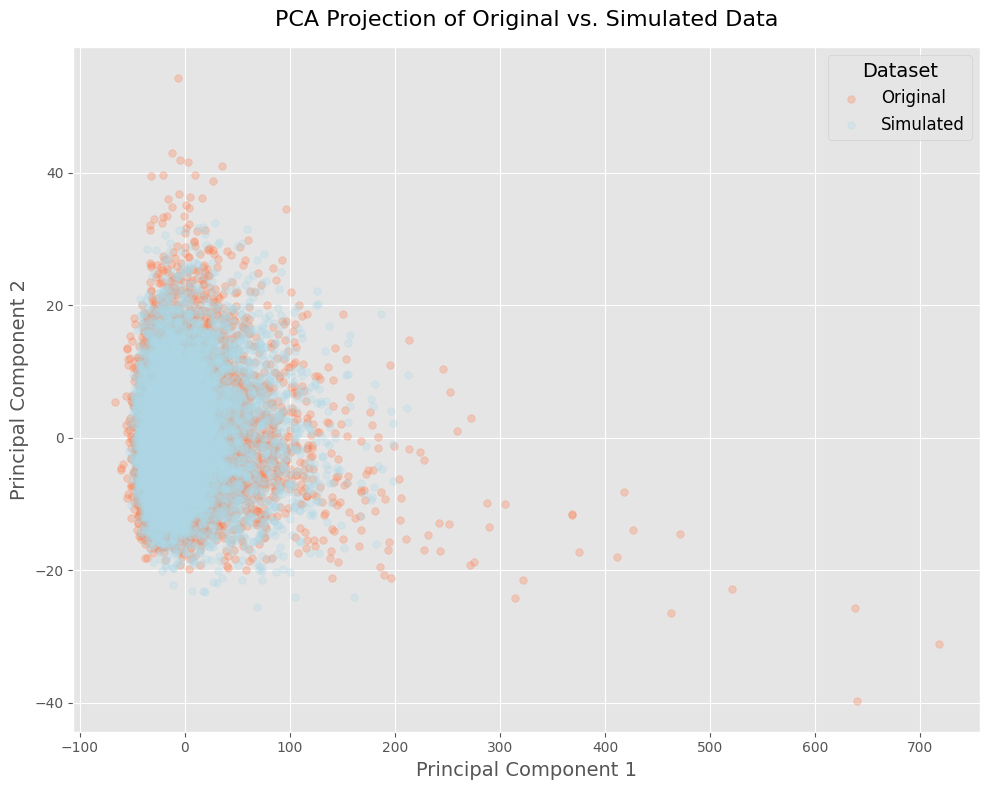

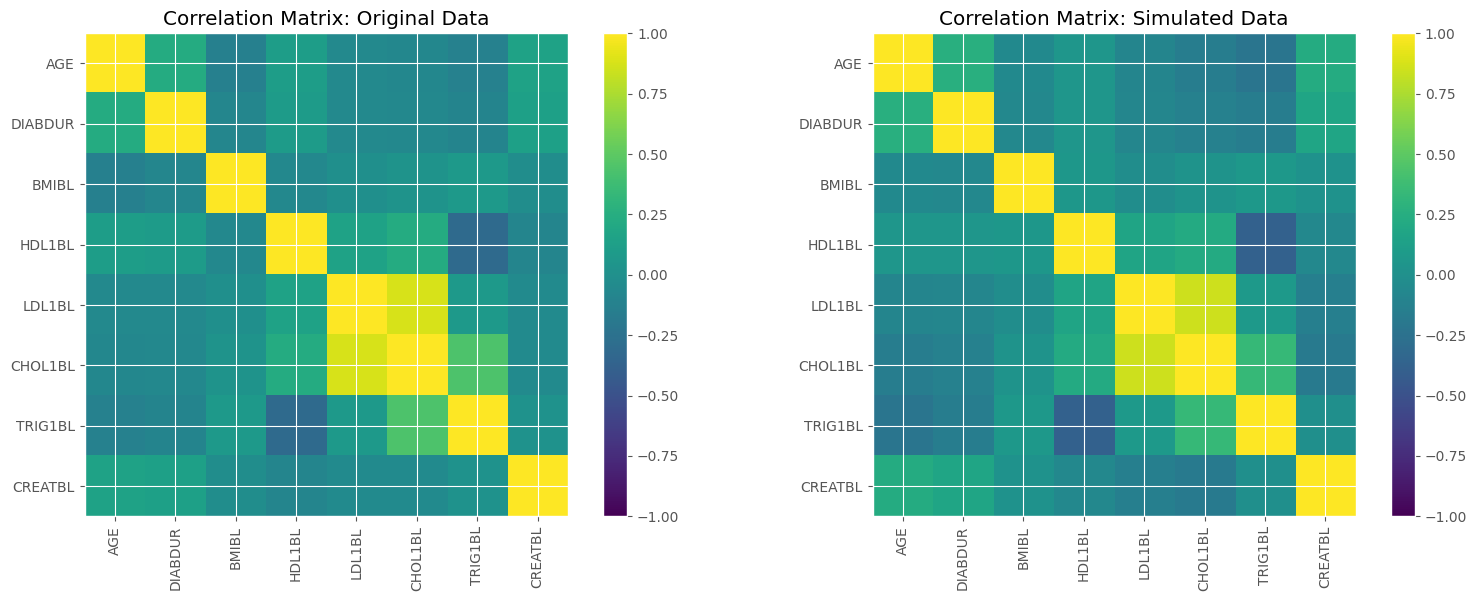

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.55      0.55      2749
           1       0.55      0.54      0.54      2748

    accuracy                           0.55      5497
   macro avg       0.55      0.55      0.55      5497
weighted avg       0.55      0.55      0.55      5497

Accuracy: 0.55
ROC AUC: 0.56


In [11]:
x,s_pred=model_bsl.sample_xz(sample_size=s_tensor.shape[0])

original_df = deepcopy(df_bsl_features)
simulated_df = pd.DataFrame(s_pred.numpy())
simulated_df.columns = original_df.columns
original_df ['source'] = 'original'
simulated_df['source'] = 'simulated'
# original_df.drop(columns={'USUBJID'},inplace=True)
combined_df = pd.concat([original_df, simulated_df], ignore_index=True)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

original_df['source'] = 'Original'
simulated_df['source'] = 'Simulated'

combined_df = pd.concat([original_df, simulated_df], ignore_index=True)
features = combined_df.drop(columns='source')
labels = combined_df['source']

# --- PCA Transformation ---
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['source'] = labels.values

style = 'seaborn' if 'seaborn' in plt.style.available else 'ggplot'
plt.style.use(style)

fig, ax = plt.subplots(figsize=(10, 8))


colors = {'Original': 'coral', 'Simulated': 'lightblue'}

for group in pca_df['source'].unique():
    group_data = pca_df[pca_df['source'] == group]
    ax.scatter(group_data['PC1'], group_data['PC2'],
               s=30, alpha=0.3, label=group, color=colors[group])

ax.set_title('PCA Projection of Original vs. Simulated Data', fontsize=16, pad=15)
ax.set_xlabel('Principal Component 1', fontsize=14)
ax.set_ylabel('Principal Component 2', fontsize=14)

ax.legend(title='Dataset', fontsize=12, title_fontsize=14, loc='best')

plt.tight_layout()
plt.show()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# ---------------------------
# 1. Population Summary Comparison
# ---------------------------
# Compute mean values for each covariate
original_df.drop(columns={'source'},inplace=True)
simulated_df.drop(columns={'source'},inplace=True)
mean_original = original_df.mean()
mean_simulated = simulated_df.mean()

# Create a grouped bar chart comparing means
x = np.arange(len(mean_original))  # positions for each covariate
width = 0.35  # width of the bars

# plt.style.use('ggplot')  # Use a beautiful built-in style
# fig, ax = plt.subplots(figsize=(12, 6))
# rects1 = ax.bar(x - width/2, mean_original, width, label='Original')
# rects2 = ax.bar(x + width/2, mean_simulated, width, label='Simulated')

# ax.set_xticks(x)
# ax.set_xticklabels(original_df.columns, rotation=45, ha='right')
# ax.set_ylabel('Mean Value')
# ax.set_title('Comparison of Mean Values by Covariate')
# ax.legend()
# plt.tight_layout()
# plt.show()


corr_original = original_df.corr()
corr_simulated = simulated_df.corr()

# Create two heatmaps side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap for original data
im0 = axes[0].imshow(corr_original, cmap='viridis', vmin=-1, vmax=1)
axes[0].set_title('Correlation Matrix: Original Data')
axes[0].set_xticks(np.arange(len(corr_original.columns)))
axes[0].set_xticklabels(corr_original.columns, rotation=90)
axes[0].set_yticks(np.arange(len(corr_original.columns)))
axes[0].set_yticklabels(corr_original.columns)
plt.colorbar(im0, ax=axes[0])

# Heatmap for simulated data
im1 = axes[1].imshow(corr_simulated, cmap='viridis', vmin=-1, vmax=1)
axes[1].set_title('Correlation Matrix: Simulated Data')
axes[1].set_xticks(np.arange(len(corr_simulated.columns)))
axes[1].set_xticklabels(corr_simulated.columns, rotation=90)
axes[1].set_yticks(np.arange(len(corr_simulated.columns)))
axes[1].set_yticklabels(corr_simulated.columns)
plt.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()


orig = original_df.copy()
sim = simulated_df.copy()

orig['label'] = 0
sim['label'] = 1

# Combine the datasets
combined_df = pd.concat([orig, sim], ignore_index=True)

# Separate features and target
X = combined_df.drop(columns=['label'])
y = combined_df['label']

# Split into training and testing sets (stratified to maintain label balance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Train a logistic regression classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Get predictions and predicted probabilities for AUC calculation
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)
print("Accuracy: {:.2f}".format(accuracy))
print("ROC AUC: {:.2f}".format(auc))

# If the two datasets are very similar, even a strong classifier should perform poorly
# (accuracy near 50% and AUC near 0.5), indicating that it is difficult to tell them apart.


In [15]:
model = FrengressionSurv(x_dim=1, y_dim=1, z_dim=1, T=11, s_dim = s_tensor.shape[1], noise_dim=1, num_layer=3, hidden_dim=100, 
                        device=device, x_binary = True, s_in_predict=True, y_binary=True)
model.train_y(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=3000, lr=1e-3, print_every_iter=1000,reg_lambda=1)

Epoch 1: loss 2179.6243,	loss_y 1.8500, 1.8581, 0.0161,	loss_eta 8.0966, 9.6322, 3.0711, 	marginal_loss 2169.6775
Epoch 1: y_sample_mean 0.013565410859882832
Epoch 1: y_sample1_cat.float().mean() 0.46038028597831726
Epoch 1000: loss 2.4485,	loss_y 0.1709, 0.2097, 0.0776,	loss_eta 2.2774, 4.8666, 5.1784, 	marginal_loss 0.0002
Epoch 1000: y_sample_mean 0.013466175645589828
Epoch 1000: y_sample1_cat.float().mean() 0.013650927692651749
Epoch 2000: loss 2.4319,	loss_y 0.1601, 0.2295, 0.1388,	loss_eta 2.2716, 5.0328, 5.5224, 	marginal_loss 0.0002
Epoch 2000: y_sample_mean 0.013535640202462673
Epoch 2000: y_sample1_cat.float().mean() 0.013434314168989658
Epoch 3000: loss 2.4249,	loss_y 0.1534, 0.2435, 0.1802,	loss_eta 2.2714, 5.0442, 5.5456, 	marginal_loss 0.0001
Epoch 3000: y_sample_mean 0.013267706148326397
Epoch 3000: y_sample1_cat.float().mean() 0.013193589635193348


In [16]:
model.train_xz(s=s_tensor, x=x_tensor, z=z_tensor, y=y_tensor, num_iters=2000, lr=1e-4, print_every_iter=500)

Epoch 1: loss 23.2591, loss1 23.3482, loss2 0.1783
Epoch 500: loss 2.4236, loss1 4.0511, loss2 3.2550
Epoch 1000: loss 2.1259, loss1 4.0742, loss2 3.8966
Epoch 1500: loss 2.0416, loss1 3.9046, loss2 3.7262
Epoch 2000: loss 1.9833, loss1 3.8266, loss2 3.6866


In [17]:
def missing_impute(y, x=None, z=None, x_dim=1, z_dim=1, missing_to_num=-1):
    # Create a copy of y to work on
    y_out = y.clone()  # or copy.deepcopy(y) if you prefer
    # Create an event indicator: 1 where y > 0, else 0.
    event_indicator = (y_out > 0).float()
    # Compute the cumulative sum along the time dimension.
    c = torch.cumsum(event_indicator, dim=1)
    # Shift the cumulative sum one time step to the right.
    c_shifted = torch.zeros_like(c)
    c_shifted[:, 1:] = c[:, :-1]
    # Create a mask that is True for time steps after the first event (i.e., where c_shifted > 0)
    mask = (c_shifted > 0)
    # Mask the y_out values after the first event.
    y_out[mask] = missing_to_num

    # If neither x nor z is provided, return only y_out.
    if x is None and z is None:
        return y_out

    n_obs, timesteps = y.shape  # infer number of observations and timesteps from y

    # Process x if provided.
    x_out = None
    if x is not None:
        # Reshape to (n_obs, timesteps, x_dim)
        x_out = x.clone().view(n_obs, timesteps, x_dim)
        # Expand mask to cover the x_dim features.
        mask_expanded = mask.unsqueeze(2).expand(-1, -1, x_dim)
        # Apply the mask to x_out.
        x_out[mask_expanded] = missing_to_num
        # Reshape x_out back to its original shape.
        x_out = x_out.view(n_obs, timesteps * x_dim)

    # Process z if provided.
    z_out = None
    if z is not None:

        # Reshape to (n_obs, timesteps, z_dim)
        z_out = z.clone().view(n_obs, timesteps, z_dim)
        # Expand mask to cover the z_dim features.
        mask_expanded = mask.unsqueeze(2).expand(-1, -1, z_dim)
        # Apply the mask to z_out.
        z_out[mask_expanded] = missing_to_num
        # Reshape z_out back to its original shape.
        z_out = z_out.view(n_obs, timesteps * z_dim)

    return x_out, z_out, y_out

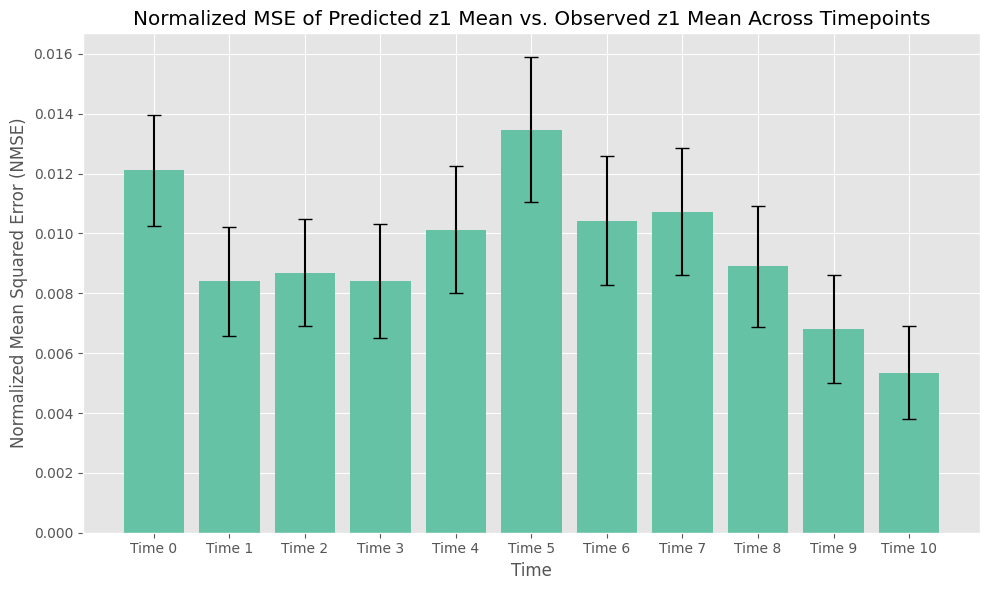

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Parameters
n_obs, total_dim = z_tensor.shape
timepoints = 11
z_dim = 1
num_samples = 500

# x_tensor, z_tensor, y_tensor = missing_impute(x=x_tensor, z=z_tensor, y=y_tensor, x_dim=1, z_dim=1)
# Reshape the observed z tensor: shape becomes (n_obs, timepoints, z_dim)
z_obs_reshaped = z_tensor.reshape(n_obs, timepoints, z_dim)
z1_obs = z_obs_reshaped[:, :, 0].detach().cpu().numpy()  # shape: (n_obs, timepoints)

# Compute the observed mean and variance (using sample variance) across observations for each timepoint
z1_obs_mean = np.mean(z1_obs, axis=0)           # shape: (timepoints,)
z1_obs_var = np.var(z1_obs, axis=0, ddof=1)       # shape: (timepoints,)

# Initialize list to collect predictions for z1
z1_samples = []

# Generate predictions in each iteration
for _ in range(num_samples):
    # Sample new predictions each time
    _, s_pred = model_bsl.sample_xz(sample_size=s_tensor.shape[0])
    x_pred, z_pred, y_pred = model.sample_joint(s=s_pred, sample_size=1)
    # x_pred, z_pred, y_pred = missing_impute(x=x_pred, z=z_pred, y=y_pred, x_dim=1, z_dim=1)
    
    # Reshape predictions: (n_obs, timepoints, z_dim)
    z_pred_reshaped = z_pred.reshape(n_obs, timepoints, z_dim)
    
    # Extract z1 and convert to numpy array
    z1_pred = z_pred_reshaped[:, :, 0].detach().cpu().numpy()
    z1_samples.append(z1_pred)

# Stack predicted samples to create an array of shape (num_samples, n_obs, timepoints)
z1_samples_array = np.stack(z1_samples, axis=0)

# For each predicted sample, compute its mean across observations (shape: (num_samples, timepoints))
z1_samples_mean = np.mean(z1_samples_array, axis=1)

# Calculate the squared errors for each sample and timepoint: (predicted mean - observed mean)^2
squared_errors = (z1_samples_mean - z1_obs_mean)**2

# Normalize squared errors by dividing by the variance at each timepoint
# This yields a normalized squared error for each sample and timepoint.
normalized_squared_errors = squared_errors / z1_obs_var

# For each timepoint, compute:
# - The mean normalized MSE across all samples
# - The standard deviation of the normalized MSE (to use as error bars)
nmse_mean = np.mean(normalized_squared_errors, axis=0)
nmse_std = np.std(normalized_squared_errors, axis=0, ddof=1)

# Create a bar plot with error bars
time = np.arange(timepoints)
plt.figure(figsize=(10, 6))
plt.bar(time, nmse_mean, yerr=nmse_std, capsize=5, color=sns.color_palette("Set2")[0])
plt.xlabel("Time")
plt.ylabel("Normalized Mean Squared Error (NMSE)")
plt.title("Normalized MSE of Predicted z1 Mean vs. Observed z1 Mean Across Timepoints")
plt.xticks(time, [f"Time {t}" for t in time])
plt.tight_layout()
plt.show()


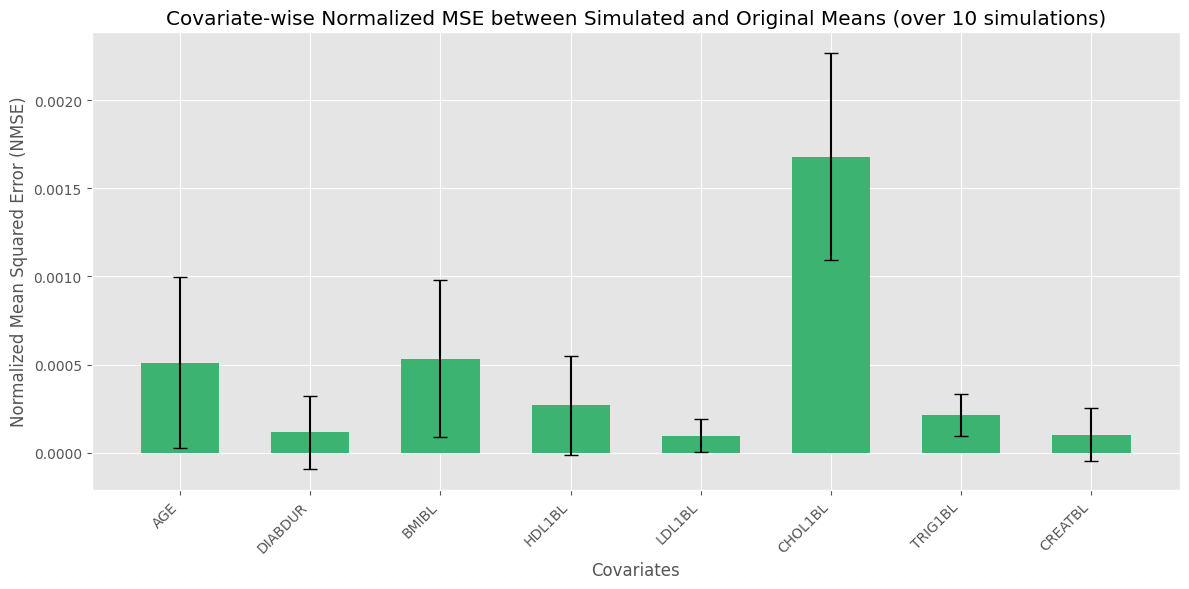

Classification Accuracy: Mean=0.554, Std=0.006, Min=0.541, Max=0.562
Classification AUC: Mean=0.575, Std=0.007, Min=0.561, Max=0.587


In [19]:

# Parameters for simulation loop
num_simulations = 10  # adjust as needed
accuracy_list = []
auc_list = []
# To store squared errors for each covariate in each simulation
covariate_squared_errors = []

# original_df is assumed to be created from df_bsl_features (the original covariate data)
original_df = deepcopy(df_bsl_features)
original_df['source'] = 'Original'
# Compute the means for the original covariates (drop any non-covariate columns if necessary)
orig_cov_means = original_df.drop(columns='source').mean()

# Compute standard deviation for each covariate in the original data
orig_cov_std = original_df.drop(columns='source').std(ddof=1)

# Initialize a list to store normalized squared errors
normalized_covariate_squared_errors = []

for i in range(num_simulations):
    # Sample s_pred (and x if needed)
    x_sim, s_pred = model_bsl.sample_xz(sample_size=s_tensor.shape[0])
    
    # Convert simulated s_pred to DataFrame with matching column names
    simulated_df = pd.DataFrame(s_pred.detach().cpu().numpy(), 
                                columns=original_df.drop(columns='source').columns)
    simulated_df['source'] = 'Simulated'
    
    # Combine original and simulated data for classification (if needed)
    combined_df = pd.concat([original_df, simulated_df], ignore_index=True)
    X = combined_df.drop(columns='source')
    y = combined_df['source'].map({'Original': 0, 'Simulated': 1})
    
    # Split data and train logistic regression as before...
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                        random_state=42, stratify=y)
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    accuracy_list.append(accuracy_score(y_test, y_pred))
    auc_list.append(roc_auc_score(y_test, y_pred_proba))
    
    # Compute the squared error between simulated and original means for each covariate
    sim_cov_means = simulated_df.drop(columns='source').mean()
    # Normalize squared error by dividing by variance (i.e., std^2)
    normalized_error = ((sim_cov_means - orig_cov_means) / orig_cov_std) ** 2
    normalized_covariate_squared_errors.append(normalized_error)

# Convert the list of normalized squared errors into a DataFrame for analysis
norm_cov_err_df = pd.DataFrame(normalized_covariate_squared_errors)

# Compute mean and std of normalized errors for each covariate
norm_mse_mean_cov = norm_cov_err_df.mean()
norm_mse_std_cov = norm_cov_err_df.std(ddof=1)

# Bar plot for normalized MSE of covariates with error bars
fig, ax = plt.subplots(figsize=(12, 6))
x_positions = np.arange(len(norm_mse_mean_cov))
width = 0.6
ax.bar(x_positions, norm_mse_mean_cov, yerr=norm_mse_std_cov, capsize=5, width=width, color='mediumseagreen')
ax.set_xticks(x_positions)
ax.set_xticklabels(norm_mse_mean_cov.index, rotation=45, ha='right')
ax.set_xlabel('Covariates')
ax.set_ylabel('Normalized Mean Squared Error (NMSE)')
ax.set_title('Covariate-wise Normalized MSE between Simulated and Original Means (over {} simulations)'.format(num_simulations))
plt.tight_layout()
plt.show()

# Print summary statistics for classification performance over simulations
print("Classification Accuracy: Mean={:.3f}, Std={:.3f}, Min={:.3f}, Max={:.3f}".format(
    np.mean(accuracy_list), np.std(accuracy_list, ddof=1), np.min(accuracy_list), np.max(accuracy_list)))
print("Classification AUC: Mean={:.3f}, Std={:.3f}, Min={:.3f}, Max={:.3f}".format(
    np.mean(auc_list), np.std(auc_list, ddof=1), np.min(auc_list), np.max(auc_list)))


In [20]:
import torch
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

# --- Preprocessing the True (Original) Joint Data using s, z1, and y ---
# Assume missing_impute is defined and the original tensors exist.
x_tensor, z_tensor, y_tensor = missing_impute(x=x_tensor, z=z_tensor, y=y_tensor, x_dim=1, z_dim=1)

# Define parameters for reshaping z
n_obs = z_tensor.shape[0]
timepoints = 11
z_dim = 1

# Convert s and y tensors to numpy arrays
s_true_np = s_tensor.detach().cpu().numpy()   # shape: (n_obs, s_dim)
y_true_np = y_tensor.detach().cpu().numpy()     # shape: (n_obs, y_dim)

# Process z: reshape and extract z1 (first dimension over time)
z_true_reshaped = z_tensor.reshape(n_obs, timepoints, z_dim)   # shape: (n_obs, timepoints, z_dim)
z1_true_np = z_true_reshaped[:, :, 0].detach().cpu().numpy()     # shape: (n_obs, timepoints)

# Create a DataFrame for the original joint data using s, z1, and y
# Name columns for s, z1 (across timepoints), and y
s_cols = [f's_{i}' for i in range(s_true_np.shape[1])]
z1_cols = [f'z1_time_{t}' for t in range(timepoints)]
y_cols = [f'y_{i}' for i in range(y_true_np.shape[1])]

# original_joint_df = pd.DataFrame(
#     np.concatenate([s_true_np, z1_true_np, y_true_np], axis=1),
#     columns = s_cols + z1_cols + y_cols
# )

original_joint_df = pd.DataFrame(
    np.concatenate([s_true_np, z1_true_np], axis=1),
    columns = s_cols+z1_cols
)
original_joint_df['source'] = 'Original'

# --- Simulation Loop ---
num_simulations = 5  # adjust as needed
accuracy_list = []
auc_list = []

for i in range(num_simulations):
    # Sample a new s_pred from the baseline model
    x_sim, s_pred = model_bsl.sample_xz(sample_size=s_tensor.shape[0])
    
    # Get joint predictions from your main model using the sampled s_pred
    x_pred, z_pred, y_pred = model.sample_joint(s=s_pred)
    
    # Apply missing data imputation to the predictions
    x_pred, z_pred, y_pred = missing_impute(x=x_pred, z=z_pred, y=y_pred, x_dim=1, z_dim=1)
    
    # Convert predicted s and y tensors to numpy arrays
    s_pred_np = s_pred.detach().cpu().numpy()    # shape: (n_obs, s_dim)
    y_pred_np = y_pred.detach().cpu().numpy()      # shape: (n_obs, y_dim)
    
    # Process predicted z: reshape and extract z1
    z_pred_reshaped = z_pred.reshape(n_obs, timepoints, z_dim)  # shape: (n_obs, timepoints, z_dim)
    z1_pred_np = z_pred_reshaped[:, :, 0].detach().cpu().numpy()  # shape: (n_obs, timepoints)
    z1_pred_np = np.round(z1_pred_np, 1)
    
    # Create a DataFrame for the simulated joint data (using s, z1, and y)
    # simulated_joint_df = pd.DataFrame(
    #     np.concatenate([s_pred_np, z1_pred_np, y_pred_np], axis=1),
    #     columns = s_cols + z1_cols + y_cols
    # )

    simulated_joint_df = pd.DataFrame(
        np.concatenate([s_pred_np, z1_pred_np], axis=1),
        columns = s_cols+z1_cols
    )
    simulated_joint_df['source'] = 'Simulated'
    
    # Combine the original and simulated joint data
    combined_joint_df = pd.concat([original_joint_df, simulated_joint_df], ignore_index=True)
    X_joint = combined_joint_df.drop(columns='source')
    y_joint = combined_joint_df['source'].map({'Original': 0, 'Simulated': 1})
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_joint, y_joint, test_size=0.3, random_state=42, stratify=y_joint
    )
    
    # Train a logistic regression classifier on the joint data (s, z1, and y)
    clf_joint = LogisticRegression(max_iter=1000)
    clf_joint.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred_class = clf_joint.predict(X_test)
    y_pred_proba = clf_joint.predict_proba(X_test)[:, 1]
    
    # Compute accuracy and AUC for this simulation iteration
    accuracy_joint = accuracy_score(y_test, y_pred_class)
    auc_joint = roc_auc_score(y_test, y_pred_proba)
    
    # Store the results
    accuracy_list.append(accuracy_joint)
    auc_list.append(auc_joint)

# --- Print Summary Statistics ---
print("Joint Data Classification Results (s, z1, and y) over {} simulations:".format(num_simulations))
print("Accuracy: Mean={:.3f}, Std={:.3f}, Min={:.3f}, Max={:.3f}".format(
    np.mean(accuracy_list), np.std(accuracy_list, ddof=1), np.min(accuracy_list), np.max(accuracy_list)))
print("AUC: Mean={:.3f}, Std={:.3f}, Min={:.3f}, Max={:.3f}".format(
    np.mean(auc_list), np.std(auc_list, ddof=1), np.min(auc_list), np.max(auc_list)))


Joint Data Classification Results (s, z1, and y) over 5 simulations:
Accuracy: Mean=0.542, Std=0.004, Min=0.539, Max=0.549
AUC: Mean=0.603, Std=0.004, Min=0.599, Max=0.609


## OK now let's train all three covariates...

In [21]:
import pandas as pd
import numpy as np
import torch
from copy import deepcopy

# ------------------------- Load Your Data -------------------------
df_z1 = deepcopy(df_hba1c)   # longitudinal covariate z1
df_z2 = deepcopy(df_egfr)    # longitudinal covariate z2
df_z3 = deepcopy(df_bmi)     # longitudinal covariate z3
df_bsl = deepcopy(df_bsl)    # baseline covariates
df_Y = deepcopy(df_Y)        # outcome
df_bsl.dropna(inplace=True)

# --------------------- Process df_Y (Outcome) ---------------------
# Ensure Y0 exists and select Y0 to Y10.
if 'Y0' not in df_Y.columns:
    df_Y.insert(1, 'Y0', 0.0)
df_Y = df_Y[['USUBJID'] + [f'Y{i}' for i in range(0, 11)]]

# ----------------- Time Points You Care About ---------------------
# (These are the actual numeric time values corresponding to Y0 ... Y10.)
time_points = [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60]

# ------------------ Compute the Event Time Mapping ------------------
# For each subject (USUBJID) in df_Y, we determine the first time when Y becomes 1.
# If no Y==1 is found, we set the event time to the maximum (60).
def compute_event_time_map(df_Y, time_points):
    event_time_map = {}
    y_cols = [f'Y{i}' for i in range(0, 11)]
    for idx, row in df_Y.iterrows():
        uid = row['USUBJID']
        event_time = None
        # Loop in order (assumes columns correspond to time_points in order)
        for tp, col in zip(time_points, y_cols):
            if row[col] == 1:
                event_time = tp
                break
        if event_time is None:
            event_time = max(time_points)
        event_time_map[uid] = event_time
    return event_time_map

event_time_map = compute_event_time_map(df_Y, time_points)

# ----------------- Revised Longitudinal Processing Function -----------------
def process_longitudinal(df, time_points, event_time_map, allowed_missing_pre_event=5):
    """
    Process the longitudinal data in df, filling missing values by backward filling 
    only for time points that occur on or before the event time for each subject.
    Count missing (NA) only among the pre-event timepoints; if the count exceeds allowed_missing_pre_event, drop the subject.
    
    Parameters:
       df: DataFrame containing USUBJID and one column per time_point (as strings)
       time_points: list of time point values, e.g. [0,6,...,60]
       event_time_map: a dictionary mapping USUBJID to the subject's event time
       allowed_missing_pre_event: threshold on the number of missing allowed (only pre-event)
    """
    # Ensure the required columns are present. Create missing time point columns as NaN.
    df = df.loc[:, ['USUBJID'] + [str(tp) for tp in time_points if str(tp) in df.columns]].copy()
    for tp in time_points:
        col = str(tp)
        if col not in df.columns:
            df.loc[:, col] = np.nan
    df = df.loc[:, ['USUBJID'] + [str(tp) for tp in time_points]]
    
    # For each subject, process each timepoint.
    indices_to_drop = []
    for idx in df.index:
        uid = df.at[idx, 'USUBJID']
        # Get the subject's event time from the mapping.
        event_time = event_time_map.get(uid, max(time_points))
        
        # For each timepoint, if the time is pre-event (<= event_time), try to fill a missing value by
        # carrying forward the previous available (non-missing) measurement.
        for t_idx, t in enumerate(time_points):
            col = str(t)
            if t <= event_time:
                if pd.isna(df.at[idx, col]):
                    # Try to fill from previous timepoints
                    for prev_t in reversed(time_points[:t_idx]):
                        prev_col = str(prev_t)
                        if not pd.isna(df.at[idx, prev_col]):
                            df.at[idx, col] = df.at[idx, prev_col]
                            break
        # Count missing values only for timepoints <= event_time.
        missing_pre_event = 0
        for t in time_points:
            if t <= event_time:
                if pd.isna(df.at[idx, str(t)]):
                    missing_pre_event += 1
        if missing_pre_event > allowed_missing_pre_event:
            indices_to_drop.append(idx)
    
    df = df.drop(index=indices_to_drop).reset_index(drop=True)
    return df

# ------------- Process and Clean z1, z2, z3 ----------------
df_z1_clean = process_longitudinal(df_z1, time_points, event_time_map)
df_z2_clean = process_longitudinal(df_z2, time_points, event_time_map)
df_z3_clean = process_longitudinal(df_z3, time_points, event_time_map)

# Note: We do not call dropna(axis=0, how='any') here because we now allow missing post-event.
# If desired, you could further filter rows if you really want no remaining NAs in the pre-event period,
# but the imputation above should have filled those.

# ------------ Align All by Intersection of USUBJID -------------
common_ids = (set(df_Y['USUBJID']) 
              & set(df_z1_clean['USUBJID']) 
              & set(df_z2_clean['USUBJID']) 
              & set(df_z3_clean['USUBJID']) 
              & set(df_bsl['USUBJID']))
df_Y = df_Y[df_Y['USUBJID'].isin(common_ids)].reset_index(drop=True)
df_z1_clean = df_z1_clean[df_z1_clean['USUBJID'].isin(common_ids)].reset_index(drop=True)
df_z2_clean = df_z2_clean[df_z2_clean['USUBJID'].isin(common_ids)].reset_index(drop=True)
df_z3_clean = df_z3_clean[df_z3_clean['USUBJID'].isin(common_ids)].reset_index(drop=True)
df_bsl = df_bsl[df_bsl['USUBJID'].isin(common_ids)].reset_index(drop=True)

# ------------ Sort all by USUBJID to align ----------------------
df_Y.sort_values(by='USUBJID', inplace=True)
df_z1_clean.sort_values(by='USUBJID', inplace=True)
df_z2_clean.sort_values(by='USUBJID', inplace=True)
df_z3_clean.sort_values(by='USUBJID', inplace=True)
df_bsl.sort_values(by='USUBJID', inplace=True)

# ----------------- Build the Z torch tensor (longitudinal) ----------------------
# For this example, we only use z1 for demonstration.
Z_list = []
for idx in range(len(df_z1_clean)):
    z1_vals = df_z1_clean.iloc[idx][[str(tp) for tp in time_points]].astype(float).values
    # If you want to include z2 and z3 use np.column_stack as in:
    Z_subj = np.column_stack([z1_vals, z2_vals, z3_vals]).reshape(-1)
    # Z_subj = z1_vals.reshape(-1)
    Z_list.append(Z_subj.astype(np.float32))

z_tensor = torch.tensor(np.vstack(Z_list), dtype=torch.float32)  # Shape (n_subjects, len(time_points))
# ----------------- Build the X tensor (ARM repeated over time) -------------------
# Pull ARM values from df_bsl; assume 'ARM' is a column.
arm_values = df_bsl['ARM'].astype(float).values  # shape (n_subjects,)
x_tensor = torch.tensor(np.repeat(arm_values[:, np.newaxis], len(time_points), axis=1), dtype=torch.int32)
# ------------------ Build the y torch tensor ----------------------
y_cols = [f'Y{i}' for i in range(0, 11)]
y_np = df_Y[y_cols].astype(float).values  # Ensure it's float so that NaN is preserved
y_tensor = torch.tensor(y_np, dtype=torch.int32)
# ----------------- Build the S tensor (baseline features) -------------------
df_bsl_features = df_bsl.drop(columns=['USUBJID','ARM',  
    'RACE_AMERICAN.INDIAN.OR.ALASKA.NATIVE',
    'RACE_NATIVE.HAWAIIAN.OR.OTHER.PACIFIC.ISLANDER',
    'RACE_OTHER',
    'RACE_ASIAN',
    'RACE_BLACK.OR.AFRICAN.AMERICAN','SEX_F', 
    'SMOKER_CURRENT.SMOKER',
    'SMOKER_NEVER.SMOKED', 
    'MIFL', 'STROKEFL', 'STENFL', 'NEPSCRFL',
    'KIDFL',"HBA1CBL"
    ])
df_bsl_features = df_bsl_features.astype(float)
x_bsl_tensor = torch.tensor(df_bsl['ARM'].values, dtype=torch.int32).view(-1, 1)
s_tensor = torch.tensor(df_bsl_features.values, dtype=torch.float32)

# ----------------- Check shape -------------------
print(f"s_tensor shape: {s_tensor.shape}")  # (n_subjects, num_baseline_features)
print(f"z_tensor shape: {z_tensor.shape}")  # (n_subjects, {len(time_points)}) 
print(f"x_tensor shape (ARM): {x_tensor.shape}")  # (n_subjects, 11)
print(f"y_tensor shape: {y_tensor.shape}")  # (n_subjects, 11)

# Optional: Sanity check USUBJID order alignment.
print(np.all(df_Y['USUBJID'].values == df_z1_clean['USUBJID'].values) and np.all(df_Y['USUBJID'].values == df_bsl['USUBJID'].values))
print(torch.isnan(y_tensor).any())  # Returns True if any NaN exists

# Optional: Count the number of 1's in a DataFrame.
# For example, to count total number of 1s in df_Y (excluding the USUBJID column):
ones_count = (df_Y.drop(columns=['USUBJID']) == 1).sum().sum()
print("Total number of 1s in df_Y:", ones_count)


s_tensor shape: torch.Size([9161, 8])
z_tensor shape: torch.Size([9161, 33])
x_tensor shape (ARM): torch.Size([9161, 11])
y_tensor shape: torch.Size([9161, 11])
True
tensor(False)
Total number of 1s in df_Y: 1267


In [22]:
model = FrengressionSurv(x_dim=1, y_dim=1, z_dim=3, T=11, s_dim = s_tensor.shape[1], noise_dim=1, num_layer=3, hidden_dim=100, 
                        device=device, x_binary = True, s_in_predict=True, y_binary=True)
model.train_y(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=5000, lr=1e-3, print_every_iter=1000,reg_lambda=1)

Epoch 1: loss 1179.7794,	loss_y 1.6489, 1.6561, 0.0142,	loss_eta 11.6033, 12.7326, 2.2586, 	marginal_loss 1166.5272
Epoch 1: y_sample_mean 0.013624951243400574
Epoch 1: y_sample1_cat.float().mean() 0.34267228841781616
Epoch 1000: loss 2.4614,	loss_y 0.1685, 0.2373, 0.1377,	loss_eta 2.2929, 4.8280, 5.0702, 	marginal_loss 0.0000
Epoch 1000: y_sample_mean 0.01322801224887371
Epoch 1000: y_sample1_cat.float().mean() 0.013295401819050312
Epoch 2000: loss 2.4470,	loss_y 0.1562, 0.2625, 0.2126,	loss_eta 2.2869, 4.8784, 5.1832, 	marginal_loss 0.0039
Epoch 2000: y_sample_mean 0.013267706148326397
Epoch 2000: y_sample1_cat.float().mean() 0.013720397837460041
Epoch 3000: loss 2.4553,	loss_y 0.1578, 0.2772, 0.2387,	loss_eta 2.2844, 4.9262, 5.2835, 	marginal_loss 0.0131
Epoch 3000: y_sample_mean 0.013416558504104614
Epoch 3000: y_sample1_cat.float().mean() 0.014837975613772869
Epoch 4000: loss 2.4445,	loss_y 0.1523, 0.2719, 0.2392,	loss_eta 2.2879, 4.9841, 5.3922, 	marginal_loss 0.0042
Epoch 4000: 

In [ ]:
model.train_y(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=5000, lr=5e-4, print_every_iter=1000,reg_lambda=1)

Epoch 1: loss 2.4650,	loss_y 0.1478, 0.2537, 0.2118,	loss_eta 2.2890, 5.0580, 5.5381, 	marginal_loss 0.0282
Epoch 1: y_sample_mean 0.01343640498816967
Epoch 1: y_sample1_cat.float().mean() 0.011691989377140999
Epoch 1000: loss 2.4393,	loss_y 0.1446, 0.2575, 0.2259,	loss_eta 2.2840, 5.0713, 5.5747, 	marginal_loss 0.0108
Epoch 1000: y_sample_mean 0.013317323289811611
Epoch 1000: y_sample1_cat.float().mean() 0.012257251888513565


In [23]:
model.train_xz(s=s_tensor, x=x_tensor, z=z_tensor, y=y_tensor, num_iters=5000, lr=1e-4, print_every_iter=500)

Epoch 1: loss 285.8455, loss1 285.9886, loss2 0.2862
Epoch 500: loss 7.3112, loss1 8.7593, loss2 2.8961
Epoch 1000: loss 5.6973, loss1 8.6120, loss2 5.8294
Epoch 1500: loss 5.2205, loss1 9.1397, loss2 7.8383
Epoch 2000: loss 4.8967, loss1 9.3454, loss2 8.8974
Epoch 2500: loss 4.5634, loss1 9.3320, loss2 9.5372
Epoch 3000: loss 4.4033, loss1 9.0203, loss2 9.2339
Epoch 3500: loss 4.2713, loss1 8.6150, loss2 8.6875
Epoch 4000: loss 4.0136, loss1 8.0646, loss2 8.1019
Epoch 4500: loss 3.7918, loss1 7.5387, loss2 7.4938
Epoch 5000: loss 3.5377, loss1 6.9605, loss2 6.8455


In [ ]:
model.train_xz(s=s_tensor, x=x_tensor, z=z_tensor, y=y_tensor, num_iters=5000, lr=1e-4, print_every_iter=500)

In [ ]:
import torch
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

# ------------------- Helper Functions -------------------

def missing_impute(y, x=None, z=None, x_dim=1, z_dim=1, missing_to_num=-1):
    """
    Apply missing data imputation on y (and optionally on x, z) by masking
    values after the first event (y>0) with the value missing_to_num.
    """
    y_out = y.clone()
    event_indicator = (y_out > 0).float()
    c = torch.cumsum(event_indicator, dim=1)
    c_shifted = torch.zeros_like(c)
    c_shifted[:, 1:] = c[:, :-1]
    mask = (c_shifted > 0)
    y_out[mask] = missing_to_num

    if x is None and z is None:
        return y_out

    n_obs, timesteps = y.shape
    x_out = None
    if x is not None:
        x_out = x.clone().view(n_obs, timesteps, x_dim)
        mask_expanded = mask.unsqueeze(2).expand(-1, -1, x_dim)
        x_out[mask_expanded] = missing_to_num
        x_out = x_out.view(n_obs, timesteps * x_dim)

    z_out = None
    if z is not None:
        z_out = z.clone().view(n_obs, timesteps, z_dim)
        mask_expanded = mask.unsqueeze(2).expand(-1, -1, z_dim)
        z_out[mask_expanded] = missing_to_num
        z_out = z_out.view(n_obs, timesteps * z_dim)

    return x_out, z_out, y_out

def impute_simulated_z(z_array, observed_idx):
    """
    Given an array z_array of shape (n_obs, n_timepoints) for a particular covariate
    (z2 or z3), impute the missing timepoints (i.e., timepoints not in observed_idx) by
    carrying forward the last observed value.
    
    Parameters:
      z_array      : numpy array of shape (n_obs, n_timepoints)
      observed_idx : list of time indices where values were originally observed.
    
    Returns:
      imputed_z : numpy array of shape (n_obs, n_timepoints) with imputed values.
    """
    imputed_z = z_array.copy()
    n_obs, n_time = imputed_z.shape
    for i in range(n_obs):
        last_val = None  # This will hold the last observed value for the current subject.
        for t in range(n_time):
            if t in observed_idx:
                last_val = imputed_z[i, t]
            else:
                if last_val is not None:
                    imputed_z[i, t] = last_val
                # If t==0 is missing (shouldn't happen if 0 is observed), you might want to set a default.
    return imputed_z

# ------------------- Time Grid and Observed Indices -------------------

# Overall time grid (11 time points)
time_points = [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60]
n_timepoints = len(time_points)

# Original measurement times for z2 and z3 are: 0, 12, 24, 36, 48, 6, 60.
# Sorted in increasing order these correspond to:
observed_idx = [0, 1, 2, 4, 6, 8, 10]

# ------------------- Preprocessing the True (Original) Joint Data -------------------

# Assume that your original tensors x_tensor, z_tensor, y_tensor, s_tensor exist and are on the proper device.
# z_tensor is assumed to have shape (n_obs, 33) where 33 = 11 timepoints * 3 covariates (z1, z2, z3).

# Apply missing imputation to original predictions.
x_tensor, z_tensor, y_tensor = missing_impute(x=x_tensor, z=z_tensor, y=y_tensor, x_dim=1, z_dim=3)

# Convert true tensors to numpy arrays.
s_true_np = s_tensor.detach().cpu().numpy()   # baseline features, shape (n_obs, s_dim)
y_true_np = y_tensor.detach().cpu().numpy()     # outcomes, shape (n_obs, 11)

# Reshape z_tensor to (n_obs, n_timepoints, 3)
n_obs = z_tensor.shape[0]
z_true_reshaped = z_tensor.reshape(n_obs, n_timepoints, 3).detach().cpu().numpy()
# For original data, we assume the imputation has been done already.
# Extract z1 (all 11 time points):
z1_true = z_true_reshaped[:, :, 0]
# For z2 and z3, we will now work with the full grid (11 time points).
# (If your original data were processed similarly via missing_impute, these values reflect that.)
z2_true = z_true_reshaped[:, :, 1]
z3_true = z_true_reshaped[:, :, 2]

# For consistency in comparison later, we now use all 11 time points for z2 and z3.
# Column names for z2 and z3 will reflect all timepoints.
s_cols = [f's_{i}' for i in range(s_true_np.shape[1])]
z1_cols = [f'z1_{t}' for t in time_points]   # 11 columns
y_cols  = [f'y_{t}'  for t in time_points]    # 11 columns
z2_cols = [f'z2_{t}' for t in time_points]     # 11 columns
z3_cols = [f'z3_{t}' for t in time_points]     # 11 columns

# Build the original joint DataFrame by concatenating s, z1, y, z2, and z3.
original_joint_df = pd.DataFrame(
    np.concatenate([s_true_np, z1_true, y_true_np, z2_true, z3_true], axis=1),
    columns = s_cols + z1_cols + y_cols + z2_cols + z3_cols
)
original_joint_df['source'] = 'Original'

# ------------------- Simulation Loop with Simulated Imputation -------------------

num_simulations = 100  
accuracy_list = []
auc_list = []

for i in range(num_simulations):
    # Sample new baseline features and (if needed) x_sim from your baseline model.
    x_sim, s_pred = model_bsl.sample_xz(sample_size=s_tensor.shape[0])
    
    # Sample joint predictions from your main model using the sampled s_pred.
    x_pred, z_pred, y_pred = model.sample_joint(s=s_pred)
    
    # Apply missing imputation on the simulated predictions.
    x_pred, z_pred, y_pred = missing_impute(x=x_pred, z=z_pred, y=y_pred, x_dim=1, z_dim=3)
    
    # Convert simulated s and y to numpy arrays.
    s_pred_np = s_pred.detach().cpu().numpy()
    y_pred_np = y_pred.detach().cpu().numpy()
    
    # Reshape z_pred to (n_obs, n_timepoints, 3)
    z_pred_reshaped = z_pred.reshape(n_obs, n_timepoints, 3).detach().cpu().numpy()
    # Extract simulated z1 from all timepoints.
    z1_pred = z_pred_reshaped[:, :, 0]
    # For z2 and z3, first extract the full grid.
    z2_pred_full = z_pred_reshaped[:, :, 1]
    z3_pred_full = z_pred_reshaped[:, :, 2]
    # Then, perform simulated imputation: for time points not in observed_idx,
    # carry forward the previous observed value.
    z2_pred_imp = impute_simulated_z(z2_pred_full, observed_idx)
    z3_pred_imp = impute_simulated_z(z3_pred_full, observed_idx)
    
    # Build the simulated joint DataFrame with all 11 time points for z1, z2, and z3.
    simulated_joint_df = pd.DataFrame(
        np.concatenate([s_pred_np, z1_pred, y_pred_np, z2_pred_imp, z3_pred_imp], axis=1),
        columns = s_cols + z1_cols + y_cols + z2_cols + z3_cols
    )
    simulated_joint_df['source'] = 'Simulated'
    
    # Combine the original and simulated joint data.
    combined_joint_df = pd.concat([original_joint_df, simulated_joint_df], ignore_index=True)
    
    X_joint = combined_joint_df.drop(columns='source')
    y_joint = combined_joint_df['source'].map({'Original': 0, 'Simulated': 1})
    
    # Split the data into training and testing sets.
    X_train, X_test, y_train, y_test = train_test_split(
        X_joint, y_joint, test_size=0.3, random_state=2025, stratify=y_joint
    )
    
    # Train the logistic regression classifier.
    clf_joint = LogisticRegression(max_iter=1000)
    clf_joint.fit(X_train, y_train)
    
    # Make predictions on the test set.
    y_joint_pred = clf_joint.predict(X_test)
    y_joint_pred_proba = clf_joint.predict_proba(X_test)[:, 1]
    
    # Compute accuracy and AUC.
    accuracy_joint = accuracy_score(y_test, y_joint_pred)
    auc_joint = roc_auc_score(y_test, y_joint_pred_proba)
    
    # Store the results.
    accuracy_list.append(accuracy_joint)
    auc_list.append(auc_joint)

# ------------------- Print Summary Statistics -------------------
print("Joint Data Classification Results with Simulated Imputation (over {} simulations):".format(num_simulations))
print("Accuracy: Mean={:.3f}, Std={:.3f}, Min={:.3f}, Max={:.3f}".format(
    np.mean(accuracy_list), np.std(accuracy_list, ddof=1), np.min(accuracy_list), np.max(accuracy_list)))
print("AUC: Mean={:.3f}, Std={:.3f}, Min={:.3f}, Max={:.3f}".format(
    np.mean(auc_list), np.std(auc_list, ddof=1), np.min(auc_list), np.max(auc_list)))


Joint Data Classification Results with Simulated Imputation (over 100 simulations):
Accuracy: Mean=0.628, Std=0.006, Min=0.615, Max=0.645
AUC: Mean=0.700, Std=0.006, Min=0.688, Max=0.716


## slicing

In [ ]:
import torch
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

# --------------------------------------------------------------------
# Helper: Missing imputation function (as you already defined)
def missing_impute(y, x=None, z=None, x_dim=1, z_dim=1, missing_to_num=-1):
    y_out = y.clone() 
    event_indicator = (y_out > 0).float()
    c = torch.cumsum(event_indicator, dim=1)
    c_shifted = torch.zeros_like(c)
    c_shifted[:, 1:] = c[:, :-1]
    mask = (c_shifted > 0)
    y_out[mask] = missing_to_num

    if x is None and z is None:
        return y_out

    n_obs, timesteps = y.shape  
    x_out = None
    if x is not None:
        x_out = x.clone().view(n_obs, timesteps, x_dim)
        mask_expanded = mask.unsqueeze(2).expand(-1, -1, x_dim)
        x_out[mask_expanded] = missing_to_num
        x_out = x_out.view(n_obs, timesteps * x_dim)

    z_out = None
    if z is not None:
        z_out = z.clone().view(n_obs, timesteps, z_dim)
        mask_expanded = mask.unsqueeze(2).expand(-1, -1, z_dim)
        z_out[mask_expanded] = missing_to_num
        z_out = z_out.view(n_obs, timesteps * z_dim)

    return x_out, z_out, y_out

# --------------------------------------------------------------------
# Define overall time grid (11 time points) and the observed indices for z2 and z3.
time_points = [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60]  # indices 0,...,10
# Given original measurement times for z2 and z3: 0, 12, 24, 36, 48, 6, 60,
# sort them into increasing order: 0, 6, 12, 24, 36, 48, 60.
# The corresponding indices in the overall time grid are:
observed_idx = [0, 1, 2, 4, 6, 8, 10]

# --------------------------------------------------------------------
# --- Preprocessing the True (Original) Joint Data ---
# Here we assume that the function missing_impute has already been applied to your original tensors.
# x_tensor, z_tensor, y_tensor, and s_tensor are assumed to exist.
# Note: z_tensor is assumed to be of shape (n_obs, 33); it stacks z1, z2, and z3, each across 11 time points.

# Apply the missing imputation to the original tensors
x_tensor, z_tensor, y_tensor = missing_impute(x=x_tensor, z=z_tensor, y=y_tensor, x_dim=1, z_dim=3)

# Convert true tensors to numpy arrays for DataFrame creation
s_true_np = s_tensor.detach().cpu().numpy()   # shape: (n_obs, s_dim)
y_true_np = y_tensor.detach().cpu().numpy()     # shape: (n_obs, 11)

# Reshape z_tensor to (n_obs, 11, 3)
n_obs = z_tensor.shape[0]
z_true_reshaped = z_tensor.reshape(n_obs, len(time_points), 3).detach().cpu().numpy()
# Extract z1: use all 11 time points
z1_true = z_true_reshaped[:, :, 0]              # shape: (n_obs, 11)
# For z2 and z3: extract only the observed indices
z2_true = z_true_reshaped[:, observed_idx, 1]     # shape: (n_obs, len(observed_idx))
z3_true = z_true_reshaped[:, observed_idx, 2]     # shape: (n_obs, len(observed_idx))

# Create column names for each block of features.
s_cols = [f's_{i}' for i in range(s_true_np.shape[1])]
z1_cols = [f'z1_{t}' for t in time_points]  # all time points for z1
y_cols  = [f'y_{t}' for t in time_points]
z2_cols = [f'z2_{time_points[i]}' for i in observed_idx]
z3_cols = [f'z3_{time_points[i]}' for i in observed_idx]

# Build the original (true) joint DataFrame by concatenating the features along the columns.
original_joint_df = pd.DataFrame(
    np.concatenate([s_true_np, z1_true, y_true_np, z2_true, z3_true], axis=1),
    columns = s_cols + z1_cols + y_cols + z2_cols + z3_cols
)
original_joint_df['source'] = 'Original'

# --------------------------------------------------------------------
# --- Simulation Loop ---
num_simulations = 100  
accuracy_list = []
auc_list = []

for i in range(num_simulations):
    # Sample from the baseline model to get new s (and x if needed)
    x_sim, s_pred = model_bsl.sample_xz(sample_size=s_tensor.shape[0])
    
    # Sample joint predictions from your main model using the simulated baseline features s_pred
    x_pred, z_pred, y_pred = model.sample_joint(s=s_pred)
    
    # Apply the missing imputation on simulated predictions.
    x_pred, z_pred, y_pred = missing_impute(x=x_pred, z=z_pred, y=y_pred, x_dim=1, z_dim=3)
    
    # Convert simulated s, y into numpy arrays.
    s_pred_np = s_pred.detach().cpu().numpy()
    y_pred_np = y_pred.detach().cpu().numpy()
    
    # Reshape simulated z_pred to (n_obs, 11, 3)
    z_pred_reshaped = z_pred.reshape(n_obs, len(time_points), 3).detach().cpu().numpy()
    # Extract the simulated z1 (all time points)
    z1_pred = z_pred_reshaped[:, :, 0]             
    # And for z2 and z3, take only the observed indices
    z2_pred = z_pred_reshaped[:, observed_idx, 1]
    z3_pred = z_pred_reshaped[:, observed_idx, 2]
    
    # Build the simulated joint DataFrame with the same feature ordering.
    simulated_joint_df = pd.DataFrame(
        np.concatenate([s_pred_np, z1_pred, y_pred_np, z2_pred, z3_pred], axis=1),
        columns = s_cols + z1_cols + y_cols + z2_cols + z3_cols
    )
    simulated_joint_df['source'] = 'Simulated'
    
    # Combine the original and simulated joint data.
    combined_joint_df = pd.concat([original_joint_df, simulated_joint_df], ignore_index=True)
    combined_joint_df= combined_joint_df.round(1)
    X_joint = combined_joint_df.drop(columns='source')
    y_joint = combined_joint_df['source'].map({'Original': 0, 'Simulated': 1})
    
    # Split the data into train and test sets.
    X_train, X_test, y_train, y_test = train_test_split(
        X_joint, y_joint, test_size=0.3, random_state=2025, stratify=y_joint
    )
    
    # Train the logistic regression classifier.
    clf_joint = LogisticRegression(max_iter=1000)
    clf_joint.fit(X_train, y_train)
    
    # Make predictions on the test set.
    y_joint_pred = clf_joint.predict(X_test)
    y_joint_pred_proba = clf_joint.predict_proba(X_test)[:, 1]
    
    # Compute accuracy and AUC.
    accuracy_joint = accuracy_score(y_test, y_joint_pred)
    auc_joint = roc_auc_score(y_test, y_joint_pred_proba)
    
    # Save the results.
    accuracy_list.append(accuracy_joint)
    auc_list.append(auc_joint)

# --- Print Summary Statistics ---
print("Joint Data Classification Results (over {} simulations):".format(num_simulations))
print("Accuracy: Mean={:.3f}, Std={:.3f}, Min={:.3f}, Max={:.3f}".format(
    np.mean(accuracy_list), np.std(accuracy_list, ddof=1), np.min(accuracy_list), np.max(accuracy_list)))
print("AUC: Mean={:.3f}, Std={:.3f}, Min={:.3f}, Max={:.3f}".format(
    np.mean(auc_list), np.std(auc_list, ddof=1), np.min(auc_list), np.max(auc_list)))


Joint Data Classification Results (over 100 simulations):
Accuracy: Mean=0.624, Std=0.006, Min=0.609, Max=0.638
AUC: Mean=0.694, Std=0.006, Min=0.680, Max=0.708


In [66]:
import torch
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

# --- Preprocessing the True (Original) Joint Data using s, z1, and y ---
# Assume missing_impute is defined and the original tensors exist.
x_tensor, z_tensor, y_tensor = missing_impute(x=x_tensor, z=z_tensor, y=y_tensor, x_dim=1, z_dim=3)

# Define parameters for reshaping z
n_obs = z_tensor.shape[0]
timepoints = 11
z_dim = 3

# Convert s and y tensors to numpy arrays
s_true_np = s_tensor.detach().cpu().numpy()   # shape: (n_obs, s_dim)
y_true_np = y_tensor.detach().cpu().numpy()     # shape: (n_obs, y_dim)

# Process z: reshape and extract z1 (first dimension over time)
z_true_reshaped = z_tensor.reshape(n_obs, timepoints, z_dim)   # shape: (n_obs, timepoints, z_dim)
z1_true_np = z_true_reshaped[:, :, 0].detach().cpu().numpy()     # shape: (n_obs, timepoints)

# Create a DataFrame for the original joint data using s, z1, and y
# Name columns for s, z1 (across timepoints), and y
s_cols = [f's_{i}' for i in range(s_true_np.shape[1])]
z1_cols = [f'z1_time_{t}' for t in range(timepoints)]
y_cols = [f'y_{i}' for i in range(y_true_np.shape[1])]

original_joint_df = pd.DataFrame(
    np.concatenate([s_true_np, z1_true_np, y_true_np], axis=1),
    columns = s_cols + z1_cols + y_cols
)

# original_joint_df = pd.DataFrame(
#     np.concatenate([s_true_np, y_true_np], axis=1),
#     columns = s_cols + y_cols
# )
original_joint_df['source'] = 'Original'

# --- Simulation Loop ---
num_simulations = 100  # adjust as needed
accuracy_list = []
auc_list = []

for i in range(num_simulations):
    # Sample a new s_pred from the baseline model
    x_sim, s_pred = model_bsl.sample_xz(sample_size=s_tensor.shape[0])
    
    # Get joint predictions from your main model using the sampled s_pred
    x_pred, z_pred, y_pred = model.sample_joint(s=s_pred)
    
    # Apply missing data imputation to the predictions
    x_pred, z_pred, y_pred = missing_impute(x=x_pred, z=z_pred, y=y_pred, x_dim=1, z_dim=3)
    
    # Convert predicted s and y tensors to numpy arrays
    s_pred_np = s_pred.detach().cpu().numpy()    # shape: (n_obs, s_dim)
    y_pred_np = y_pred.detach().cpu().numpy()      # shape: (n_obs, y_dim)
    
    # Process predicted z: reshape and extract z1
    z_pred_reshaped = z_pred.reshape(n_obs, timepoints, z_dim)  # shape: (n_obs, timepoints, z_dim)
    z1_pred_np = z_pred_reshaped[:, :, 0].detach().cpu().numpy()  # shape: (n_obs, timepoints)
    z1_pred_np = np.round(z1_pred_np, 1)
    
    # Create a DataFrame for the simulated joint data (using s, z1, and y)
    simulated_joint_df = pd.DataFrame(
        np.concatenate([s_pred_np, z1_pred_np, y_pred_np], axis=1),
        columns = s_cols + z1_cols + y_cols
    )

    # simulated_joint_df = pd.DataFrame(
    #     np.concatenate([s_pred_np, y_pred_np], axis=1),
    #     columns = s_cols + y_cols
    # )
    simulated_joint_df['source'] = 'Simulated'
    
    # Combine the original and simulated joint data
    combined_joint_df = pd.concat([original_joint_df, simulated_joint_df], ignore_index=True)
    X_joint = combined_joint_df.drop(columns='source')
    y_joint = combined_joint_df['source'].map({'Original': 0, 'Simulated': 1})
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_joint, y_joint, test_size=0.3, random_state=42, stratify=y_joint
    )
    
    # Train a logistic regression classifier on the joint data (s, z1, and y)
    clf_joint = LogisticRegression(max_iter=1000)
    clf_joint.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred_class = clf_joint.predict(X_test)
    y_pred_proba = clf_joint.predict_proba(X_test)[:, 1]
    
    # Compute accuracy and AUC for this simulation iteration
    accuracy_joint = accuracy_score(y_test, y_pred_class)
    auc_joint = roc_auc_score(y_test, y_pred_proba)
    
    # Store the results
    accuracy_list.append(accuracy_joint)
    auc_list.append(auc_joint)

# --- Print Summary Statistics ---
print("Joint Data Classification Results (s, z1, and y) over {} simulations:".format(num_simulations))
print("Accuracy: Mean={:.3f}, Std={:.3f}, Min={:.3f}, Max={:.3f}".format(
    np.mean(accuracy_list), np.std(accuracy_list, ddof=1), np.min(accuracy_list), np.max(accuracy_list)))
print("AUC: Mean={:.3f}, Std={:.3f}, Min={:.3f}, Max={:.3f}".format(
    np.mean(auc_list), np.std(auc_list, ddof=1), np.min(auc_list), np.max(auc_list)))


Joint Data Classification Results (s, z1, and y) over 100 simulations:
Accuracy: Mean=0.703, Std=0.007, Min=0.689, Max=0.722
AUC: Mean=0.766, Std=0.006, Min=0.750, Max=0.782


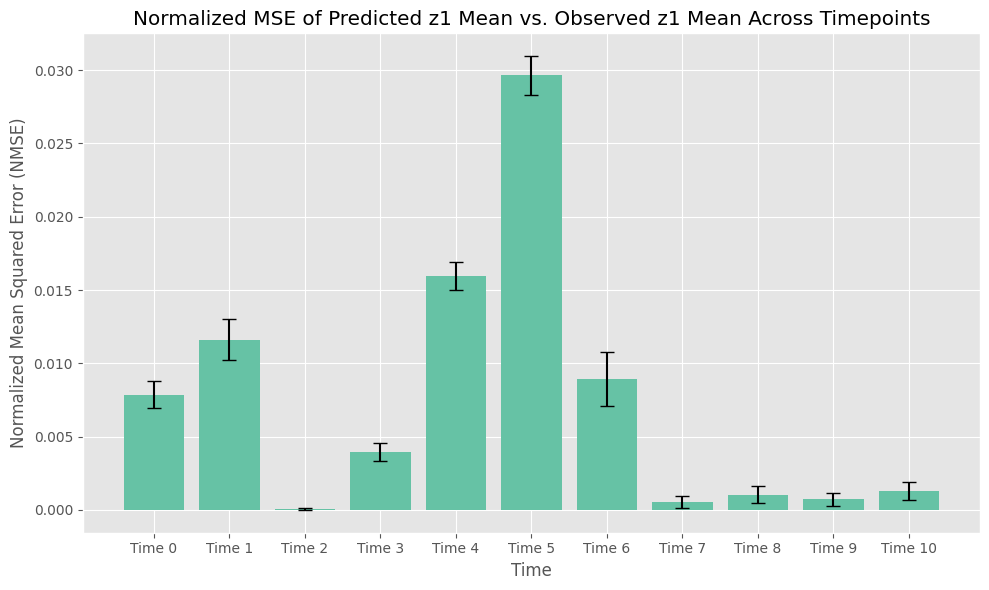

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Parameters
n_obs, total_dim = z_tensor.shape
timepoints = 11
z_dim = 3
num_samples = 500

x_tensor, z_tensor, y_tensor = missing_impute(x=x_tensor, z=z_tensor, y=y_tensor, x_dim=1, z_dim=3)
# Reshape the observed z tensor: shape becomes (n_obs, timepoints, z_dim)
z_obs_reshaped = z_tensor.reshape(n_obs, timepoints, z_dim)
z1_obs = z_obs_reshaped[:, :, 0].detach().cpu().numpy()  # shape: (n_obs, timepoints)

# Compute the observed mean and variance (using sample variance) across observations for each timepoint
z1_obs_mean = np.mean(z1_obs, axis=0)           # shape: (timepoints,)
z1_obs_var = np.var(z1_obs, axis=0, ddof=1)       # shape: (timepoints,)

# Initialize list to collect predictions for z1
z1_samples = []

# Generate predictions in each iteration
for _ in range(num_samples):
    # Sample new predictions each time
    _, s_pred = model_bsl.sample_xz(sample_size=s_tensor.shape[0])
    x_pred, z_pred, y_pred = model.sample_joint(s=s_pred)
    x_pred, z_pred, y_pred = missing_impute(x=x_pred, z=z_pred, y=y_pred, x_dim=1, z_dim=3)
    
    # Reshape predictions: (n_obs, timepoints, z_dim)
    z_pred_reshaped = z_pred.reshape(n_obs, timepoints, z_dim)
    
    # Extract z1 and convert to numpy array
    z1_pred = z_pred_reshaped[:, :, 0].detach().cpu().numpy()
    z1_samples.append(z1_pred)

# Stack predicted samples to create an array of shape (num_samples, n_obs, timepoints)
z1_samples_array = np.stack(z1_samples, axis=0)

# For each predicted sample, compute its mean across observations (shape: (num_samples, timepoints))
z1_samples_mean = np.mean(z1_samples_array, axis=1)

# Calculate the squared errors for each sample and timepoint: (predicted mean - observed mean)^2
squared_errors = (z1_samples_mean - z1_obs_mean)**2

# Normalize squared errors by dividing by the variance at each timepoint
# This yields a normalized squared error for each sample and timepoint.
normalized_squared_errors = squared_errors / z1_obs_var

# For each timepoint, compute:
# - The mean normalized MSE across all samples
# - The standard deviation of the normalized MSE (to use as error bars)
nmse_mean = np.mean(normalized_squared_errors, axis=0)
nmse_std = np.std(normalized_squared_errors, axis=0, ddof=1)

# Create a bar plot with error bars
time = np.arange(timepoints)
plt.figure(figsize=(10, 6))
plt.bar(time, nmse_mean, yerr=nmse_std, capsize=5, color=sns.color_palette("Set2")[0])
plt.xlabel("Time")
plt.ylabel("Normalized Mean Squared Error (NMSE)")
plt.title("Normalized MSE of Predicted z1 Mean vs. Observed z1 Mean Across Timepoints")
plt.xticks(time, [f"Time {t}" for t in time])
plt.tight_layout()
plt.show()


## do nothing 

In [ ]:
import torch
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

# --- Preprocessing the True (Original) Joint Data ---
# Assume that missing_impute is defined and the original tensors (x_tensor, z_tensor, y_tensor, s_tensor) exist.
x_tensor, z_tensor, y_tensor = missing_impute(x=x_tensor, z=z_tensor, y=y_tensor, x_dim=1, z_dim=3)

# Convert the true tensors to numpy arrays (s_true_np is used as part of the joint features)
s_true_np = s_tensor.detach().cpu().numpy()
z_true_np = z_tensor.detach().cpu().numpy()
y_true_np = y_tensor.detach().cpu().numpy()

# Create a DataFrame for the original joint data
original_joint_df = pd.DataFrame(
    np.concatenate([s_true_np, z_true_np, y_true_np], axis=1),
    columns=[f's_{i}' for i in range(s_true_np.shape[1])] +
            [f'z_{i}' for i in range(z_true_np.shape[1])] +
            [f'y_{i}' for i in range(y_true_np.shape[1])]
)
original_joint_df['source'] = 'Original'

# --- Simulation Loop ---
num_simulations = 100  # adjust as needed
accuracy_list = []
auc_list = []

for i in range(num_simulations):
    # Sample a new s_pred (and x_sim if needed) from the baseline model
    x_sim, s_pred = model_bsl.sample_xz(sample_size=s_tensor.shape[0])
    
    # Get joint predictions from your main model using the sampled s_pred
    x_pred, z_pred, y_pred = model.sample_joint(s=s_pred)
    
    # Apply missing data imputation to the predictions
    x_pred, z_pred, y_pred = missing_impute(x=x_pred, z=z_pred, y=y_pred, x_dim=1, z_dim=3)
    
    # Convert predicted tensors to numpy arrays
    s_pred_np = s_pred.detach().cpu().numpy()
    z_pred_np = z_pred.detach().cpu().numpy()
    y_pred_np = y_pred.detach().cpu().numpy()
    
    # Create a DataFrame for the simulated joint data
    simulated_joint_df = pd.DataFrame(
        np.concatenate([s_pred_np, z_pred_np, y_pred_np], axis=1),
        columns=[f's_{i}' for i in range(s_pred_np.shape[1])] +
                [f'z_{i}' for i in range(z_pred_np.shape[1])] +
                [f'y_{i}' for i in range(y_pred_np.shape[1])]
    )
    simulated_joint_df['source'] = 'Simulated'
    
    # Combine the original and simulated joint data
    combined_joint_df = pd.concat([original_joint_df, simulated_joint_df], ignore_index=True)
    X_joint = combined_joint_df.drop(columns='source')
    y_joint = combined_joint_df['source'].map({'Original': 0, 'Simulated': 1})
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_joint, y_joint, test_size=0.3, random_state=2025, stratify=y_joint
    )
    
    # Train a logistic regression classifier on the joint data
    clf_joint = LogisticRegression(max_iter=1000)
    clf_joint.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_joint_pred = clf_joint.predict(X_test)
    y_joint_pred_proba = clf_joint.predict_proba(X_test)[:, 1]
    
    # Compute accuracy and AUC for the simulation iteration
    accuracy_joint = accuracy_score(y_test, y_joint_pred)
    auc_joint = roc_auc_score(y_test, y_joint_pred_proba)
    
    # Store the results
    accuracy_list.append(accuracy_joint)
    auc_list.append(auc_joint)

# --- Print Summary Statistics ---
print("Joint Data Classification Results (over {} simulations):".format(num_simulations))
print("Accuracy: Mean={:.3f}, Std={:.3f}, Min={:.3f}, Max={:.3f}".format(
    np.mean(accuracy_list), np.std(accuracy_list, ddof=1), np.min(accuracy_list), np.max(accuracy_list)))
print("AUC: Mean={:.3f}, Std={:.3f}, Min={:.3f}, Max={:.3f}".format(
    np.mean(auc_list), np.std(auc_list, ddof=1), np.min(auc_list), np.max(auc_list)))
